# Tensorboard로 모델, 데이터, 학습 시각화하기

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=transforms)
testset = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False, transform=transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

net = Net()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TensorBoard에 기록하기

In [13]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('./runs')

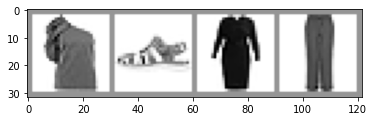

In [14]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)


## Tensorboard를 사용하여 모델 살펴보기

In [15]:
writer.add_graph(net, images)
writer.close()

## Tensorboard에 "Projector" 추가하기

In [16]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(labels))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

class_labels = [classes[lab] for lab in labels]

features = images.view(-1,28*28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

projector를 사용하면 경로 설정 잘해주기  
일반적으로 터미널에 tensorboard --logdir=경로 를 적으면 텐서보드 활성화됨  
근데 projector의 경우, 경로가 달라질 수 있으니 해당 경로가 맞는 경로인지 다시 확인해보기

## Tensorboard로 모델 학습 추적하기

In [27]:
def images_to_probs(net, images):
    output = net(images)
    _,preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4,idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(classes[preds[idx]], probs[idx]*100.0, classes[labels[idx]]), color=('green' if preds[idx]==labels[idx].item() else "red"))
    
    return fig

In [28]:
running_loss = 0.0
for epoch in range(1):
    
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            writer.add_scalar('training loss', running_loss/1000, epoch*len(trainloader) + i)
            writer.add_figure('prediction vs. actual', plot_classes_preds(net, inputs, labels), global_step=epoch*len(trainloader)+i)
            
            running_loss = 0.0

print('Finished Training')

Finished Training


## Tensorboard로 학습된 모델 평가하기

In [31]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
# 실행하는데 10초 이하 소요
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)